In [17]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import chainer

In [2]:
cd ../

C:\Users\akite\OneDrive\デスクトップ\source code\twitter-compe


In [6]:
train_df = pd.read_csv('./data/preprosessing_train.csv')

In [7]:
X_df_train = train_df[["is_url","is_location","num_emoji","num_reply","num_hash","text_length","num_kusa","is_date","is_time","text_wakati"]]
Y_df_train = train_df["flg"].astype(np.int64)
X_train =  X_df_train.values
y_train = Y_df_train.values
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, random_state=1)


In [8]:
X_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20285 entries, 0 to 20284
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   is_url       20285 non-null  float64
 1   is_location  20285 non-null  float64
 2   num_emoji    20285 non-null  float64
 3   num_reply    20285 non-null  float64
 4   num_hash     20285 non-null  float64
 5   text_length  20285 non-null  float64
 6   num_kusa     20285 non-null  float64
 7   is_date      20285 non-null  float64
 8   is_time      20285 non-null  float64
 9   text_wakati  20285 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cv = CountVectorizer()
# トレーニング用データにCountVectorizerを適用
X_train_cv = cv.fit_transform(X_train[:,9])
print(X_train[:,:8].shape)

# バリデーション用データにCountVectorizerを適用
X_valid_cv = cv.transform(X_valid[:,9])


(16228, 8)


In [16]:
X_valid[:,9]

array([0., 0., 0., ..., 0., 0., 0.])

In [10]:
#countvectorizerを適用した配列と特徴量の配列を結合する
X_train = np.concatenate([X_train_cv.toarray(),X_train[:,:8]],1)
X_valid = np.concatenate([X_valid_cv.toarray(),X_valid[:,:8]],1)

In [11]:
X_train = X_train.astype(np.float64)
X_valid = X_valid.astype(np.float64)

In [12]:
from scipy.sparse import csr_matrix
X_train_csr = csr_matrix(X_train)

In [13]:
X_valid_csr = csr_matrix(X_valid)

In [18]:
print(X_valid_csr.shape)
print(X_train_csr.shape)

(4057, 33366)
(16228, 33366)


In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score, recall_score,f1_score
import seaborn as sns
def result_heatmap(Y_test,Y_pred):
    print("正解率:"+str(accuracy_score(Y_test, Y_pred)))
    print("適合率:"+str(recall_score(Y_test,Y_pred)))
    print("再現率:"+str(precision_score(Y_test,Y_pred)))
    print("F値:"+str(f1_score(Y_test, Y_pred)))  
    cm = confusion_matrix(Y_test, Y_pred)
    print(cm)
    sns.heatmap(cm,annot=True, cmap='Blues')

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500,
                                    random_state=1)
model.fit(X_train_csr, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

正解率:0.9689425684002958
適合率:0.5795053003533569
再現率:0.9590643274853801
F値:0.722466960352423
[[3767    7]
 [ 119  164]]


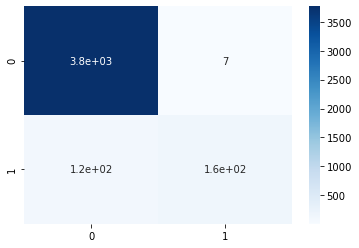

In [18]:
#普通にやると全部違う方に分類される
y_pred = model.predict(X_valid_csr)
result_heatmap(y_valid,y_pred)

In [14]:
#ロジスティック
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe_lr = make_pipeline(
                       LogisticRegression(penalty="l2",C=10,random_state=1))
                       

正解率:0.9620409169336949
適合率:0.6537102473498233
再現率:0.7676348547717843
F値:0.7061068702290076


c:\users\akite\onedrive\デスクトップ\source code\twitter-compe\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


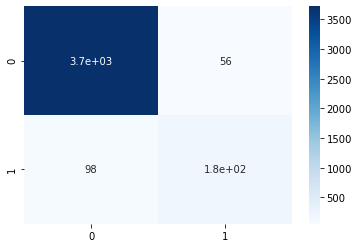

In [15]:
pipe_lr.fit(X_train_csr,y_train)
y_pred = pipe_lr.predict(X_valid_csr)
result_heatmap(y_valid,y_pred)

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


param_range = [ 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
param_grid = [{'logisticregression__C': param_range, 
               'logisticregression__penalty': ['l1']},
              {'logisticregression__C': param_range, 
               'logisticregression__penalty': ['l2']}]

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='f1', 
                  cv=5,
                  n_jobs=-1)
gs = gs.fit(X_train_csr, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.7249662093322315
{'logisticregression__C': 10.0, 'logisticregression__penalty': 'l2'}


c:\users\akite\onedrive\デスクトップ\source code\twitter-compe\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [35]:

import chainer.links as L
import chainer.functions as F
from chainer import Sequential

# net としてインスタンス化
n_input = X_train_csr.shape[0]
n_hidden = 1000
n_output = 2

net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

In [36]:
optimizer = chainer.optimizers.SGD(lr=0.01)

In [37]:
optimizer.setup(net)

In [38]:
n_epoch = 30
n_batchsize = 16

In [40]:

iteration = 0

# ログの保存用
results_train = {
    'loss': [],
    'accuracy': []
}
results_valid = {
    'loss': [],
    'accuracy': []
}


for epoch in range(n_epoch):

    # データセット並べ替えた順番を取得
    order = np.random.permutation(range(X_train_csr.shape[0]))

    # 各バッチ毎の目的関数の出力と分類精度の保存用
    loss_list = []
    accuracy_list = []

    for i in range(0, len(order), n_batchsize):
        # バッチを準備
        index = order[i:i+n_batchsize]
        x_train_batch = X_train_csr[index,:]
        t_train_batch = y_train[index]

        # 予測値を出力
        y_train_batch = net(x_train_batch)

        # 目的関数を適用し、分類精度を計算
        loss_train_batch = F.softmax_cross_entropy(y_train_batch, t_train_batch)
        accuracy_train_batch = F.accuracy(y_train_batch, t_train_batch)

        loss_list.append(loss_train_batch.array)
        accuracy_list.append(accuracy_train_batch.array)

        # 勾配のリセットと勾配の計算
        net.cleargrads()
        loss_train_batch.backward()

        # パラメータの更新
        optimizer.update()

        # カウントアップ
        iteration += 1

    # 訓練データに対する目的関数の出力と分類精度を集計
    loss_train = np.mean(loss_list)
    accuracy_train = np.mean(accuracy_list)

    # 1エポック終えたら、検証データで評価
    # 検証データで予測値を出力
    with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
        y_val = net(x_val)

    # 目的関数を適用し、分類精度を計算
    loss_val = F.softmax_cross_entropy(y_val, t_val)
    accuracy_val = F.accuracy(y_val, t_val)

    # 結果の表示
    print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'.format(
        epoch, iteration, loss_train, loss_val.array))

    # ログを保存
    results_train['loss'] .append(loss_train)
    results_train['accuracy'] .append(accuracy_train)
    results_valid['loss'].append(loss_val.array)
    results_valid['accuracy'].append(accuracy_val.array)

TypeError: incompatible array types are mixed in the forward input (LinearFunction).
Actual: <class 'scipy.sparse.csr.csr_matrix'>, <class 'numpy.ndarray'>, <class 'numpy.ndarray'>